## Openspot Model Performance Evalution Tool

In [ ]:
# import libraries and custom modules
import os
import io
import time
import requests
import zipfile
import torch
import numpy as np
import matplotlib.pyplot as plt

print("You are currently in the directory:", os.getcwd())

from dataset import acpds
from utils import transforms
from utils import visualize as vis

You are currently in the directory: /Users/elliott/Documents/GitHub/OpenSpot


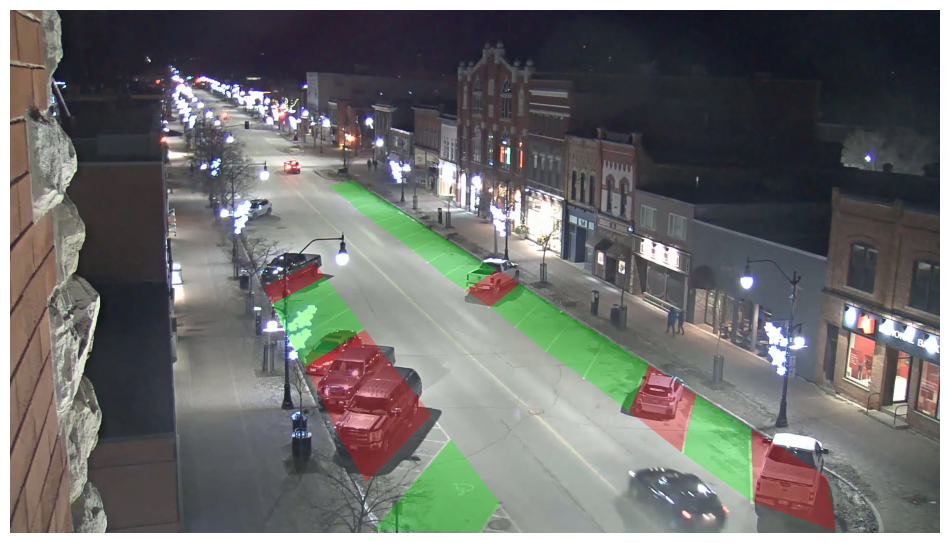

/Users/elliott/miniforge3/envs/ucal/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/elliott/miniforge3/envs/ucal/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [ ]:
# ===============================================================
# 1. LOAD DATASET, MODEL, AND WEIGHTS, AND VISUALIZE SAMPLE IMAGE
# ===============================================================

train_ds, valid_ds, test_ds = acpds.create_datasets('dataset/data')

image_batch, rois_batch, labels_batch = next(iter(valid_ds))
image_raw, rois, labels = image_batch[0], rois_batch[0], labels_batch[0]
image = transforms.preprocess(image_raw, res=1080)
vis.plot_ds_image(image, rois, labels, show=True)

# create model
from models.rcnn import RCNN
model = RCNN()

# load model weights
weights_path = 'out_dir/RCNN_v2/weights_last_epoch.pt'
model.load_state_dict(torch.load(weights_path, map_location='cpu'))

In [ ]:

# =============================================
# 2. EVALUATE SAMPLE PREDICTIONS ON TEST SET
# =============================================
for i, (image_batch, rois_batch, labels_batch) in enumerate(test_ds):
    if i == 2: break
    image, rois, labels = image_batch[0], rois_batch[0], labels_batch[0]
    image = transforms.preprocess(image)
    with torch.no_grad():
        class_logits = model(image, rois)
        class_scores = class_logits.softmax(1)[:, 1]
    vis.plot_ds_image(image, rois, class_scores, labels)    

In [ ]:

# =============================================
# 3. FIND INCORRECT CLASSIFICATIONS ON TEST
# =============================================
THRESHOLD = 0.5

# Collect all images with errors
error_images = []

for i, (image_batch, rois_batch, labels_batch) in enumerate(test_ds):
    image, rois, labels = image_batch[0], rois_batch[0], labels_batch[0]
    image_proc = transforms.preprocess(image)
    
    with torch.no_grad():
        class_logits = model(image_proc, rois)
        class_scores = class_logits.softmax(1)[:, 1]
    
    predictions = (class_scores >= THRESHOLD).int()
    
    if not torch.equal(predictions, labels.int()):
        error_images.append({
            'idx': i,
            'image': image,
            'rois': rois,
            'labels': labels,
            'scores': class_scores,
            'predictions': predictions,
            'num_errors': (predictions != labels.int()).sum().item()
        })

print(f"Found {len(error_images)} images with errors out of {i+1} total")

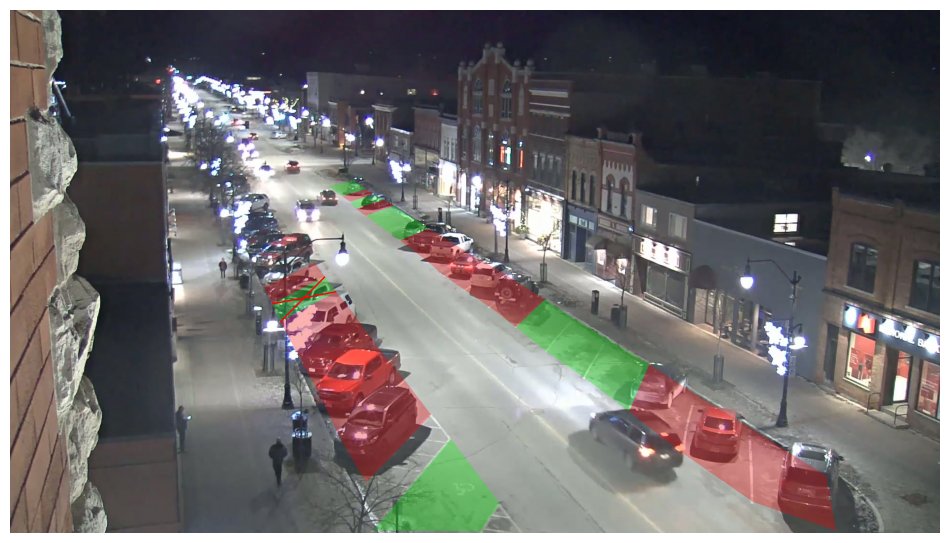

Image index: 4, Errors: 1


In [ ]:
# ===============================================
# 4. VISUALIZE SPECIFIC INCORRECT CLASSIFICATIONS
# ===============================================
img_data = error_images[0]  # Change index to browse different error images
vis.plot_ds_image(
    transforms.preprocess(img_data['image']), 
    img_data['rois'], 
    img_data['scores'], 
    img_data['labels']
)
print(f"Image index: {img_data['idx']}, Errors: {img_data['num_errors']}")

In [ ]:

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
from tqdm import tqdm

# ==========================================
# 4. EVALUATE OVERALL PERFORMANCE ON TEST SET
# ==========================================
y_true = []
y_pred = []

model.eval()

print("\nEvaluating test set performance...")

for image_batch, rois_batch, labels_batch in tqdm(test_ds):
    image = transforms.preprocess(image_batch[0])
    rois = rois_batch[0]
    labels = labels_batch[0].numpy()

    with torch.no_grad():
        logits = model(image, rois)
        preds = logits.softmax(1)[:, 1].numpy()
        preds_binary = (preds >= 0.5).astype(int)

    y_true.extend(labels.tolist())
    y_pred.extend(preds_binary.tolist())

# Compute global test metrics
test_accuracy = accuracy_score(y_true, y_pred)
test_precision = precision_score(y_true, y_pred)
test_recall = recall_score(y_true, y_pred)
test_f1 = f1_score(y_true, y_pred)

print("\n=== TEST SET PERFORMANCE ===")
print(f"Accuracy : {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall   : {test_recall:.4f}")
print(f"F1-score : {test_f1:.4f}")


In [ ]:
# ================================
# 3. COMPUTE PER-ROI METRICS ON TRAINING SET
# ================================
roi_records = []

print("\nComputing per-ROI performance on testing set...")

for image_batch, rois_batch, labels_batch in tqdm(test_ds):
    image = transforms.preprocess(image_batch[0])
    rois = rois_batch[0]
    labels = labels_batch[0].numpy()

    with torch.no_grad():
        logits = model(image, rois)
        preds = logits.softmax(1)[:, 1].numpy()
        preds_binary = (preds >= 0.5).astype(int)

    # Loop through ROIs individually
    for i, roi in enumerate(rois):
        roi_records.append({
            "roi_index": i,
            "true_label": int(labels[i]),
            "pred_label": int(preds_binary[i]),
            "probability": float(preds[i])
        })

# Convert to DataFrame
df = pd.DataFrame(roi_records)

# Compute metrics per ROI index
roi_metrics = df.groupby("roi_index").apply(
    lambda x: pd.Series({
        "precision": precision_score(x["true_label"], x["pred_label"]),
        "recall": recall_score(x["true_label"], x["pred_label"]),
        "f1_score": f1_score(x["true_label"], x["pred_label"])
    })
)

# Save CSV
output_csv = "roi_performance_metrics.csv"
roi_metrics.to_csv(output_csv)
print(f"\nROI metrics saved to: {output_csv}")
